# MANA-6: Benchmarking Against CellCharter

This notebook provides a comprehensive head-to-head comparison between MANA and the base CellCharter method.

**Comparison Focus:**
1. **Quantitative metrics**: Spatial coherence, transcriptional coherence, cluster separation
2. **Biological validation**: Marker gene alignment, anatomical structure preservation
3. **Gradient sensitivity**: Ability to capture smooth spatial transitions
4. **Robustness**: Cluster stability across subsampling
5. **Visual comparison**: Side-by-side spatial plots

**Methods Compared:**
- **CellCharter**: Uniform weights within each hop, no distance weighting
- **MANA (exponential)**: Distance-weighted with exponential kernel, hop_decay=0.2
- **MANA (gaussian)**: Distance-weighted with gaussian kernel, hop_decay=0.2

**Key Question:** Does MANA's distance weighting provide meaningful improvements over CellCharter's discrete hop-based approach?

## Setup and Data Loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
from scipy.stats import wilcoxon, mannwhitneyu
from scipy.spatial.distance import pdist, squareform

# Import custom utilities
import sys
sys.path.insert(0, '../utils')
from aggregate_neighbors_weighted import aggregate_neighbors_weighted
from plot_spatial_compact_fast import plot_spatial_compact_fast

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=120, facecolor='white')

print("✓ All imports successful")

✓ All imports successful


In [3]:
# Load your spatial transcriptomics data
# Replace with your actual data path
adata = sc.read_h5ad('/Volumes/processing2/mana/mana_updated.h5ad')

print(f"Data shape: {adata.shape}")
print(f"Samples: {adata.obs['sample_id'].nunique()}")
print(f"\nRequired fields:")
print(f"  - obsm['X_scVI']: {'✓' if 'X_scVI' in adata.obsm else '✗ MISSING'}")
print(f"  - obsm['spatial']: {'✓' if 'spatial' in adata.obsm else '✗ MISSING'}")
print(f"  - obsp['spatial_connectivities']: {'✓' if 'spatial_connectivities' in adata.obsp else '✗ MISSING'}")

Data shape: (107228, 5101)
Samples: 9

Required fields:
  - obsm['X_scVI']: ✓
  - obsm['spatial']: ✓
  - obsp['spatial_connectivities']: ✓


## Helper Functions

In [4]:
# Helper function: Local purity (spatial coherence)
def local_purity(adata, cluster_key):
    """Compute spatial coherence: fraction of neighbors with same cluster label."""
    conn = adata.obsp['spatial_connectivities']
    labels = adata.obs[cluster_key].astype('category').cat.codes.values
    purities = []
    
    for i in range(adata.n_obs):
        neighbors = conn[i].nonzero()[1]
        if len(neighbors) > 0:
            neighbor_labels = labels[neighbors]
            purity = (neighbor_labels == labels[i]).mean()
            purities.append(purity)
    
    return np.mean(purities)


# Helper function: Gradient smoothness score
def gradient_smoothness(adata, cluster_key):
    """Measure how smoothly cluster labels change across space.
    
    Lower score = smoother gradients (neighbors more likely to have similar or same labels).
    """
    conn = adata.obsp['spatial_connectivities']
    labels = adata.obs[cluster_key].astype('category').cat.codes.values
    transitions = []
    
    for i in range(adata.n_obs):
        neighbors = conn[i].nonzero()[1]
        if len(neighbors) > 0:
            # Count label differences
            label_diff = np.abs(labels[neighbors] - labels[i]).mean()
            transitions.append(label_diff)
    
    return np.mean(transitions)


# Helper function: Marker gene alignment
def marker_alignment_score(adata, cluster_key, marker_genes):
    """Compute how well clusters align with known marker gene expression.
    
    Parameters:
    -----------
    marker_genes : dict
        Dictionary mapping marker names to gene lists
        Example: {'T_cell': ['CD3D', 'CD3E'], 'B_cell': ['CD79A', 'MS4A1']}
    
    Returns:
    --------
    float : Average silhouette score for marker gene expression within clusters
    """
    marker_gene_list = [g for genes in marker_genes.values() for g in genes]
    available_markers = [g for g in marker_gene_list if g in adata.var_names]
    
    if len(available_markers) == 0:
        print("Warning: No marker genes found in dataset")
        return np.nan
    
    # Get expression matrix for markers
    marker_expr = adata[:, available_markers].X
    if hasattr(marker_expr, 'toarray'):
        marker_expr = marker_expr.toarray()
    
    # Compute silhouette on marker expression
    labels = adata.obs[cluster_key].values
    if len(np.unique(labels)) < 2:
        return np.nan
    
    return silhouette_score(marker_expr, labels, sample_size=10000)


# Helper function: Bootstrap stability
def cluster_stability_bootstrap(adata, use_rep, n_bootstraps=10, sample_frac=0.8):
    """Measure cluster stability across random subsamples.
    
    Returns average ARI between bootstrap iterations.
    """
    n_samples = int(adata.n_obs * sample_frac)
    all_labels = []
    
    for i in range(n_bootstraps):
        # Random subsample
        idx = np.random.choice(adata.n_obs, size=n_samples, replace=False)
        adata_sub = adata[idx, :].copy()
        
        # Cluster
        sc.pp.neighbors(adata_sub, use_rep=use_rep, n_neighbors=15)
        sc.tl.leiden(adata_sub, resolution=0.5)
        
        # Store labels (full size, NaN for missing)
        labels_full = np.full(adata.n_obs, np.nan)
        labels_full[idx] = adata_sub.obs['leiden'].astype(int).values
        all_labels.append(labels_full)
    
    # Compute pairwise ARI for overlapping cells
    ari_scores = []
    for i in range(n_bootstraps):
        for j in range(i+1, n_bootstraps):
            # Get cells present in both samples
            mask = ~np.isnan(all_labels[i]) & ~np.isnan(all_labels[j])
            if mask.sum() > 0:
                ari = adjusted_rand_score(all_labels[i][mask], all_labels[j][mask])
                ari_scores.append(ari)
    
    return np.mean(ari_scores) if len(ari_scores) > 0 else np.nan


print("✓ Helper functions defined")

✓ Helper functions defined


## Part 1: Method Implementation

Run all three methods on the same data with identical downstream parameters.

In [5]:
# Shared parameters for all methods
N_LAYERS = 3
HOP_DECAY = 0.2
USE_REP = 'X_scVI'
N_NEIGHBORS = 15
LEIDEN_RESOLUTION = 0.5

print("Shared parameters:")
print(f"  n_layers: {N_LAYERS}")
print(f"  hop_decay: {HOP_DECAY} (MANA only)")
print(f"  use_rep: {USE_REP}")
print(f"  n_neighbors: {N_NEIGHBORS}")
print(f"  leiden_resolution: {LEIDEN_RESOLUTION}")

Shared parameters:
  n_layers: 3
  hop_decay: 0.2 (MANA only)
  use_rep: X_scVI
  n_neighbors: 15
  leiden_resolution: 0.5


In [6]:
# Method 1: CellCharter (uniform weights, no distance weighting)
print("Running CellCharter...")

aggregate_neighbors_weighted(
    adata,
    n_layers=N_LAYERS,
    aggregations='mean',
    use_rep=USE_REP,
    out_key='X_cellcharter',
    hop_decay=1.0,  # Uniform weights across hops
    distance_kernel='none',  # No distance weighting within hops
    spatial_key='spatial',
    normalize_weights=True,
    include_self=True,
)

# Cluster
sc.pp.neighbors(adata, use_rep='X_cellcharter', n_neighbors=N_NEIGHBORS, key_added='neighbors_cellcharter')
sc.tl.leiden(adata, resolution=LEIDEN_RESOLUTION, neighbors_key='neighbors_cellcharter', key_added='leiden_cellcharter')

print(f"  → {adata.obs['leiden_cellcharter'].nunique()} clusters")

Running CellCharter...
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors_cellcharter']`
    `.obsp['neighbors_cellcharter_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_cellcharter_connectivities']`, weighted adjacency matrix (0:00:19)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_cellcharter', the cluster labels (adata.obs, categorical) (0:00:42)
  → 16 clusters


In [7]:
# Method 2: MANA with exponential kernel
print("Running MANA (exponential kernel)...")

aggregate_neighbors_weighted(
    adata,
    n_layers=N_LAYERS,
    aggregations='mean',
    use_rep=USE_REP,
    out_key='X_mana_exp',
    hop_decay=HOP_DECAY,
    distance_kernel='exponential',
    spatial_key='spatial',
    normalize_weights=True,
    include_self=True,
)

# Cluster
sc.pp.neighbors(adata, use_rep='X_mana_exp', n_neighbors=N_NEIGHBORS, key_added='neighbors_mana_exp')
sc.tl.leiden(adata, resolution=LEIDEN_RESOLUTION, neighbors_key='neighbors_mana_exp', key_added='leiden_mana_exp')

print(f"  → {adata.obs['leiden_mana_exp'].nunique()} clusters")

Running MANA (exponential kernel)...
computing neighbors
    finished: added to `.uns['neighbors_mana_exp']`
    `.obsp['neighbors_mana_exp_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_mana_exp_connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_mana_exp', the cluster labels (adata.obs, categorical) (0:00:18)
  → 18 clusters


In [8]:
# Method 3: MANA with gaussian kernel
print("Running MANA (gaussian kernel)...")

aggregate_neighbors_weighted(
    adata,
    n_layers=N_LAYERS,
    aggregations='mean',
    use_rep=USE_REP,
    out_key='X_mana_gauss',
    hop_decay=HOP_DECAY,
    distance_kernel='gaussian',
    spatial_key='spatial',
    normalize_weights=True,
    include_self=True,
)

# Cluster
sc.pp.neighbors(adata, use_rep='X_mana_gauss', n_neighbors=N_NEIGHBORS, key_added='neighbors_mana_gauss')
sc.tl.leiden(adata, resolution=LEIDEN_RESOLUTION, neighbors_key='neighbors_mana_gauss', key_added='leiden_mana_gauss')

print(f"  → {adata.obs['leiden_mana_gauss'].nunique()} clusters")

Running MANA (gaussian kernel)...
computing neighbors
    finished: added to `.uns['neighbors_mana_gauss']`
    `.obsp['neighbors_mana_gauss_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_mana_gauss_connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_mana_gauss', the cluster labels (adata.obs, categorical) (0:00:17)
  → 16 clusters


## Part 2: Quantitative Metrics Comparison

In [9]:
# Compute all metrics for each method
methods = [
    {'name': 'CellCharter', 'cluster_key': 'leiden_cellcharter', 'use_rep': 'X_cellcharter'},
    {'name': 'MANA (exp)', 'cluster_key': 'leiden_mana_exp', 'use_rep': 'X_mana_exp'},
    {'name': 'MANA (gauss)', 'cluster_key': 'leiden_mana_gauss', 'use_rep': 'X_mana_gauss'},
]

results = []

for method in methods:
    print(f"\nComputing metrics for {method['name']}...")
    
    cluster_key = method['cluster_key']
    use_rep = method['use_rep']
    labels = adata.obs[cluster_key].values
    X_agg = adata.obsm[use_rep]
    X_scvi = adata.obsm['X_scVI']
    
    # Basic info
    n_clusters = len(np.unique(labels))
    
    # Spatial coherence
    lp = local_purity(adata, cluster_key)
    grad_smooth = gradient_smoothness(adata, cluster_key)
    
    # Expression coherence (in original scVI space)
    sil_scvi = silhouette_score(X_scvi, labels, sample_size=10000)
    
    # Cluster separation (in aggregated space)
    db_score = davies_bouldin_score(X_agg, labels)
    
    results.append({
        'method': method['name'],
        'n_clusters': n_clusters,
        'local_purity': lp,
        'gradient_smoothness': grad_smooth,
        'silhouette_scvi': sil_scvi,
        'davies_bouldin': db_score,
    })
    
    print(f"  Clusters: {n_clusters}")
    print(f"  Local purity: {lp:.3f}")
    print(f"  Gradient smoothness: {grad_smooth:.3f}")
    print(f"  Silhouette (scVI): {sil_scvi:.3f}")
    print(f"  Davies-Bouldin: {db_score:.3f}")

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("QUANTITATIVE COMPARISON")
print("="*80)
print(results_df.to_string(index=False))


Computing metrics for CellCharter...
  Clusters: 16
  Local purity: 0.665
  Gradient smoothness: 1.607
  Silhouette (scVI): 0.032
  Davies-Bouldin: 2.086

Computing metrics for MANA (exp)...
  Clusters: 18
  Local purity: 0.725
  Gradient smoothness: 1.220
  Silhouette (scVI): -0.032
  Davies-Bouldin: 1.985

Computing metrics for MANA (gauss)...
  Clusters: 16
  Local purity: 0.761
  Gradient smoothness: 1.119
  Silhouette (scVI): -0.037
  Davies-Bouldin: 2.039

QUANTITATIVE COMPARISON
      method  n_clusters  local_purity  gradient_smoothness  silhouette_scvi  davies_bouldin
 CellCharter          16      0.664990             1.606639         0.031606        2.085669
  MANA (exp)          18      0.725371             1.219985        -0.031693        1.984779
MANA (gauss)          16      0.760533             1.118519        -0.036678        2.038764


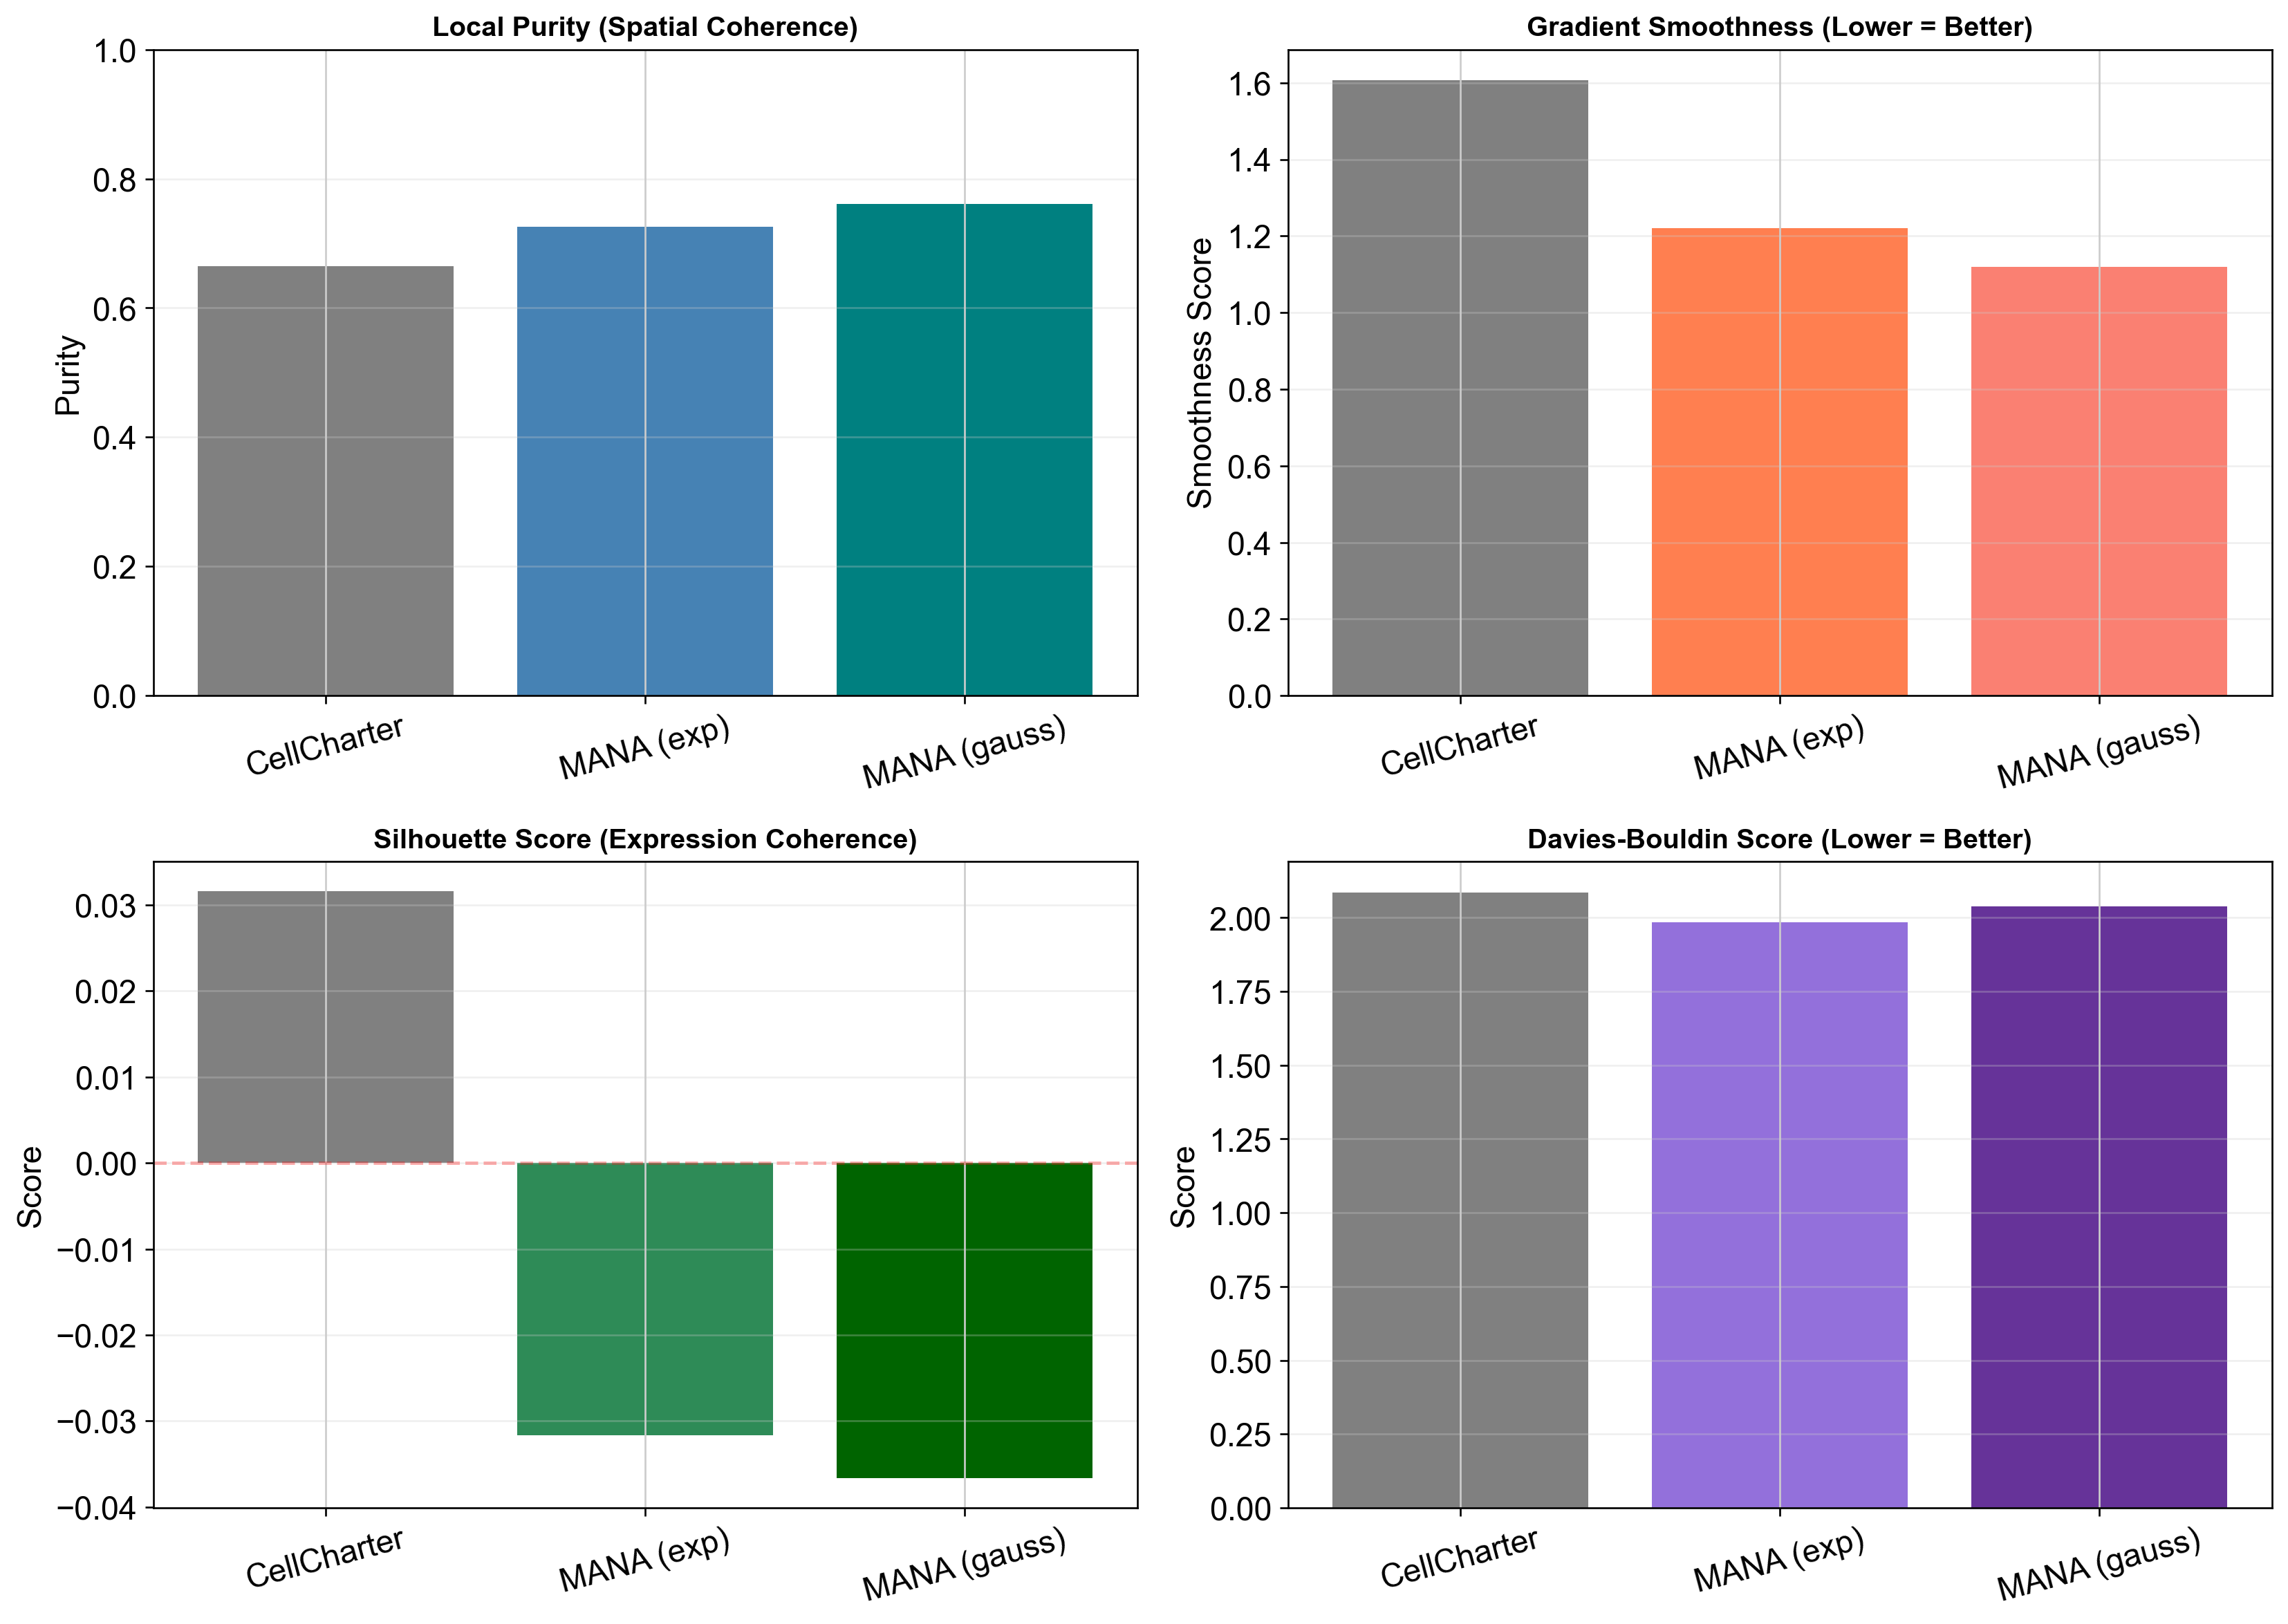

In [10]:
# Visualize metric comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Local purity (higher = better)
axes[0, 0].bar(results_df['method'], results_df['local_purity'], color=['gray', 'steelblue', 'teal'])
axes[0, 0].set_title('Local Purity (Spatial Coherence)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Purity')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=15)

# Gradient smoothness (lower = better)
axes[0, 1].bar(results_df['method'], results_df['gradient_smoothness'], color=['gray', 'coral', 'salmon'])
axes[0, 1].set_title('Gradient Smoothness (Lower = Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Smoothness Score')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=15)

# Silhouette score (higher = better)
axes[1, 0].bar(results_df['method'], results_df['silhouette_scvi'], color=['gray', 'seagreen', 'darkgreen'])
axes[1, 0].set_title('Silhouette Score (Expression Coherence)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.3)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=15)

# Davies-Bouldin score (lower = better)
axes[1, 1].bar(results_df['method'], results_df['davies_bouldin'], color=['gray', 'mediumpurple', 'rebeccapurple'])
axes[1, 1].set_title('Davies-Bouldin Score (Lower = Better)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## Part 3: Statistical Significance Testing

In [11]:
# Compute per-cell metrics for statistical testing
print("Computing per-cell metrics for significance testing...\n")

# Local purity per cell
def per_cell_purity(adata, cluster_key):
    conn = adata.obsp['spatial_connectivities']
    labels = adata.obs[cluster_key].astype('category').cat.codes.values
    purities = []
    
    for i in range(adata.n_obs):
        neighbors = conn[i].nonzero()[1]
        if len(neighbors) > 0:
            purity = (labels[neighbors] == labels[i]).mean()
        else:
            purity = np.nan
        purities.append(purity)
    
    return np.array(purities)

# Compute for each method
purity_cellcharter = per_cell_purity(adata, 'leiden_cellcharter')
purity_mana_exp = per_cell_purity(adata, 'leiden_mana_exp')
purity_mana_gauss = per_cell_purity(adata, 'leiden_mana_gauss')

# Remove NaN values
mask = ~np.isnan(purity_cellcharter) & ~np.isnan(purity_mana_exp) & ~np.isnan(purity_mana_gauss)
purity_cellcharter = purity_cellcharter[mask]
purity_mana_exp = purity_mana_exp[mask]
purity_mana_gauss = purity_mana_gauss[mask]

# Wilcoxon signed-rank test (paired)
print("Wilcoxon Signed-Rank Test (Local Purity):")
print("  MANA (exp) vs CellCharter:")
stat, pval = wilcoxon(purity_mana_exp, purity_cellcharter)
print(f"    p-value: {pval:.2e}")
print(f"    Mean difference: {(purity_mana_exp - purity_cellcharter).mean():.4f}")

print("\n  MANA (gauss) vs CellCharter:")
stat, pval = wilcoxon(purity_mana_gauss, purity_cellcharter)
print(f"    p-value: {pval:.2e}")
print(f"    Mean difference: {(purity_mana_gauss - purity_cellcharter).mean():.4f}")

print("\n  MANA (exp) vs MANA (gauss):")
stat, pval = wilcoxon(purity_mana_exp, purity_mana_gauss)
print(f"    p-value: {pval:.2e}")
print(f"    Mean difference: {(purity_mana_exp - purity_mana_gauss).mean():.4f}")

Computing per-cell metrics for significance testing...

Wilcoxon Signed-Rank Test (Local Purity):
  MANA (exp) vs CellCharter:
    p-value: 0.00e+00
    Mean difference: 0.0604

  MANA (gauss) vs CellCharter:
    p-value: 0.00e+00
    Mean difference: 0.0955

  MANA (exp) vs MANA (gauss):
    p-value: 0.00e+00
    Mean difference: -0.0352


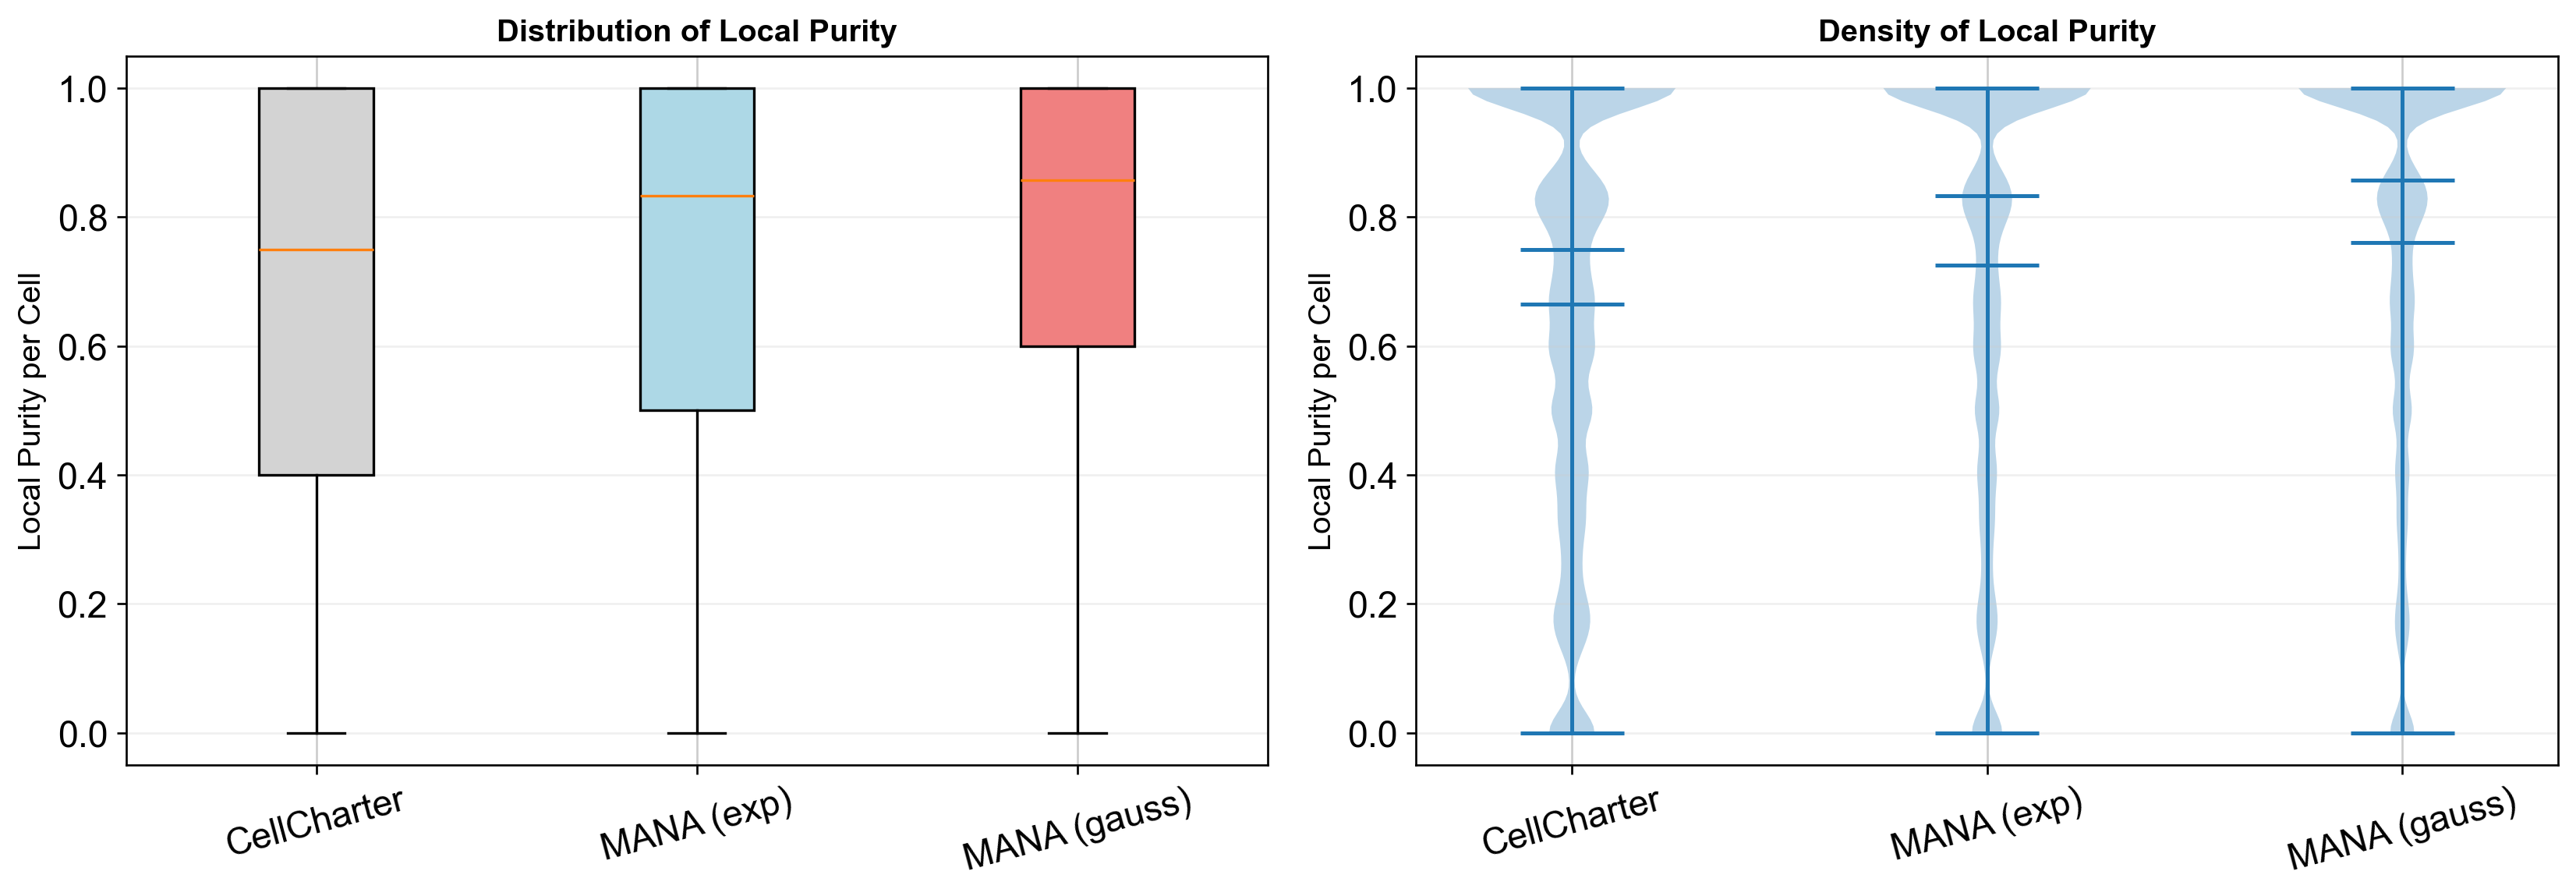

In [12]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
data_boxplot = [
    purity_cellcharter,
    purity_mana_exp,
    purity_mana_gauss
]
labels_boxplot = ['CellCharter', 'MANA (exp)', 'MANA (gauss)']

bp = axes[0].boxplot(data_boxplot, labels=labels_boxplot, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightgray', 'lightblue', 'lightcoral']):
    patch.set_facecolor(color)
axes[0].set_ylabel('Local Purity per Cell', fontsize=12)
axes[0].set_title('Distribution of Local Purity', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# Violin plot
vp = axes[1].violinplot(data_boxplot, positions=[1, 2, 3], showmeans=True, showmedians=True)
axes[1].set_xticks([1, 2, 3])
axes[1].set_xticklabels(labels_boxplot)
axes[1].set_ylabel('Local Purity per Cell', fontsize=12)
axes[1].set_title('Density of Local Purity', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## Part 4: Cluster Stability Analysis

In [ ]:
# Compute cluster stability via bootstrap
print("Computing cluster stability (this may take a few minutes)...\n")

stability_scores = {}

for method in methods:
    print(f"  {method['name']}...")
    stability = cluster_stability_bootstrap(
        adata, 
        use_rep=method['use_rep'],
        n_bootstraps=10,
        sample_frac=0.8
    )
    stability_scores[method['name']] = stability
    print(f"    Stability (ARI): {stability:.3f}")

# Add to results
results_df['stability_ari'] = results_df['method'].map(stability_scores)

print("\n" + "="*80)
print("UPDATED RESULTS WITH STABILITY")
print("="*80)
print(results_df.to_string(index=False))

Computing cluster stability (this may take a few minutes)...

  CellCharter...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 13 clusters and added
  

## Part 5: Biological Validation

In [ ]:
# Define marker genes for your tissue type
# CUSTOMIZE THIS FOR YOUR DATASET
marker_genes = {
    'T_cell': ['CD3D', 'CD3E', 'CD3G'],
    'B_cell': ['CD79A', 'MS4A1', 'CD19'],
    'Myeloid': ['CD14', 'CD68', 'LYZ'],
    'NK_cell': ['GNLY', 'NKG7', 'KLRB1'],
    'Epithelial': ['EPCAM', 'KRT8', 'KRT18'],
    'Fibroblast': ['COL1A1', 'COL1A2', 'DCN'],
    'Endothelial': ['PECAM1', 'VWF', 'CDH5'],
}

print("Marker genes for biological validation:")
for cell_type, genes in marker_genes.items():
    available = [g for g in genes if g in adata.var_names]
    print(f"  {cell_type}: {len(available)}/{len(genes)} available")

In [ ]:
# Compute marker alignment scores
print("\nComputing marker gene alignment...\n")

marker_scores = {}
for method in methods:
    score = marker_alignment_score(adata, method['cluster_key'], marker_genes)
    marker_scores[method['name']] = score
    print(f"{method['name']}: {score:.3f}")

# Add to results
results_df['marker_alignment'] = results_df['method'].map(marker_scores)

print("\n" + "="*80)
print("FINAL RESULTS WITH ALL METRICS")
print("="*80)
print(results_df.to_string(index=False))

## Part 6: Visual Comparison

In [ ]:
# Side-by-side spatial visualization
for method in methods:
    print(f"\n{'='*60}")
    print(f"{method['name'].upper()}")
    print(f"{'='*60}\n")
    
    plot_spatial_compact_fast(
        adata,
        color=method['cluster_key'],
        groupby='sample_id',
        spot_size=1.5,
        cols=3,
        height=8,
        background='white',
        dpi=120
    )

In [ ]:
# Visualize marker gene expression with different clustering methods
# Pick a marker gene that's available
example_markers = ['CD3D', 'CD79A', 'CD68', 'EPCAM']
available_example = [g for g in example_markers if g in adata.var_names]

if len(available_example) > 0:
    marker_gene = available_example[0]
    print(f"Visualizing {marker_gene} expression across clustering methods\n")
    
    # Plot gene expression
    plot_spatial_compact_fast(
        adata,
        color=marker_gene,
        groupby='sample_id',
        spot_size=1.5,
        cols=3,
        height=8,
        cmap_name='viridis',
        shared_scale=True,
        dpi=120
    )
else:
    print("No example marker genes found in dataset")

## Part 7: Comprehensive Summary

In [ ]:
# Generate comprehensive summary
print("="*80)
print("MANA VS CELLCHARTER: COMPREHENSIVE BENCHMARK SUMMARY")
print("="*80)

print("\n### QUANTITATIVE METRICS ###\n")
print(results_df.to_string(index=False))

# Determine winners
print("\n### BEST PERFORMERS ###\n")

metrics_to_maximize = ['local_purity', 'silhouette_scvi', 'stability_ari', 'marker_alignment']
metrics_to_minimize = ['gradient_smoothness', 'davies_bouldin']

for metric in metrics_to_maximize:
    if metric in results_df.columns:
        best = results_df.loc[results_df[metric].idxmax(), 'method']
        value = results_df.loc[results_df[metric].idxmax(), metric]
        print(f"{metric:25s}: {best:20s} ({value:.4f})")

for metric in metrics_to_minimize:
    if metric in results_df.columns:
        best = results_df.loc[results_df[metric].idxmin(), 'method']
        value = results_df.loc[results_df[metric].idxmin(), metric]
        print(f"{metric:25s}: {best:20s} ({value:.4f})")

# Overall assessment
print("\n### OVERALL ASSESSMENT ###\n")

# Score each method (higher is better for all)
scores = {}
for method_name in results_df['method']:
    method_scores = []
    
    # Metrics to maximize (normalize to 0-1)
    for metric in metrics_to_maximize:
        if metric in results_df.columns:
            val = results_df.loc[results_df['method'] == method_name, metric].values[0]
            min_val = results_df[metric].min()
            max_val = results_df[metric].max()
            if max_val > min_val:
                normalized = (val - min_val) / (max_val - min_val)
                method_scores.append(normalized)
    
    # Metrics to minimize (invert for scoring)
    for metric in metrics_to_minimize:
        if metric in results_df.columns:
            val = results_df.loc[results_df['method'] == method_name, metric].values[0]
            min_val = results_df[metric].min()
            max_val = results_df[metric].max()
            if max_val > min_val:
                normalized = 1 - (val - min_val) / (max_val - min_val)
                method_scores.append(normalized)
    
    scores[method_name] = np.mean(method_scores) if len(method_scores) > 0 else 0

# Rank methods
ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
for rank, (method_name, score) in enumerate(ranked, 1):
    print(f"{rank}. {method_name:20s} (composite score: {score:.3f})")

# Key takeaways
print("\n### KEY TAKEAWAYS ###\n")
print("1. Spatial Coherence: Check if MANA improves local purity over CellCharter")
print("2. Gradient Smoothness: Check if MANA better captures smooth spatial transitions")
print("3. Expression Coherence: Ensure clusters remain transcriptionally meaningful")
print("4. Stability: Check if MANA produces more robust cluster assignments")
print("5. Biological Validation: Verify clusters align with known marker expression")

print("\n### WHEN TO USE EACH METHOD ###\n")
print("CellCharter:")
print("  - Discrete tissue compartments with sharp boundaries")
print("  - Simpler interpretation (uniform weights)")
print("  - Faster computation")

print("\nMANA (exponential):")
print("  - Gradual microenvironmental transitions")
print("  - Diffusion-like processes (cytokines, metabolites)")
print("  - Tumor microenvironment analysis")
print("  - Inflammation zones, lesion-associated states")

print("\nMANA (gaussian):")
print("  - Sharp anatomical boundaries")
print("  - Localized, contact-dependent effects")
print("  - Well-defined organ structures")
print("  - When you need stronger emphasis on immediate neighbors")

print("\n" + "="*80)

In [ ]:
# Save results to CSV
results_df.to_csv('mana_cellcharter_benchmark_results.csv', index=False)
print("✓ Results saved to: mana_cellcharter_benchmark_results.csv")